In [3]:
!pip install pingouin

In [4]:
import pandas as pd
import numpy as np
import math
from scipy.stats import chi2, anderson, probplot, yeojohnson
from scipy import stats 
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pingouin import multivariate_normality
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def calculateMahalanobis(y=None, data=None, cov=None):
  
    y_mu = y - data.mean(axis=0)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

def mardia(data):
    mtx = data.values
    n, k = mtx.shape
    
    mean_mtx = np.array([ np.mean(mtx, axis=0) for i in range(n)])
    S = np.cov(mtx, rowvar=False)*(n-1)/n
    SI =  np.linalg.inv(S)
    dist_pt1 = np.dot(mtx-mean_mtx, SI)
    dist_pt2 = (mtx-mean_mtx).T
    distm = np.dot(dist_pt1, dist_pt2)
    
    gl = k*(k+1)*(k+2)/6
    AM = np.sum(distm**3)/n**2
    
    if(n<30): # Small samples
        c = (n+1)*(n+3)*(k+1)/(n*((n+1)*(k+1)-6))
        TAM = n*c/6*AM
    else:
        TAM = n/6*AM
    p_value_sk =  chi2.sf(TAM, df =gl)

    KM = np.sum((np.diag(distm))**2)/n
    TKM = (KM-k*(k+2))*math.sqrt(n/(8*k*(k+2)))
    TKM = TKM**2
    p_value_kurt =  chi2.sf(TKM, df =1)
    
    print("Multivariate Skewness", AM)
    print("Statistic", TAM)
    print("P-Value", p_value_sk )
    print("Normality", "No"if p_value_sk<0.05 else "yes")

    
    print("\nMultivariate Kurtosis", KM)
    print("Statistic", TKM)
    print("P-Value", p_value_kurt) 
    print("Normality", "No"if p_value_kurt<0.05 else "yes")

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.
    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N    


# Data

In [5]:
df = pd.read_csv("mercurio.csv")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
0,1,Alligator,5.9,6.1,3.0,0.7,1.23,5,0.85,1.43,1.53,1
1,2,Annie,3.5,5.1,1.9,3.2,1.33,7,0.92,1.90,1.33,0
2,3,Apopka,116.0,9.1,44.1,128.3,0.04,6,0.04,0.06,0.04,0
3,4,Blue Cypress,39.4,6.9,16.4,3.5,0.44,12,0.13,0.84,0.44,0
4,5,Brick,2.5,4.6,2.9,1.8,1.20,12,0.69,1.50,1.33,1


In [6]:
data = df.iloc[:, 2:]

# Multivariate Normality Test (All Columns)

## Mardia

In [7]:
mardia(data)

Multivariate Skewness 56.90573699461316
Statistic 502.6673434524163
P-Value 3.627769397753002e-24
Normality No

Multivariate Kurtosis 140.56710967185447
Statistic 23.35345626402786
P-Value 1.3480107591351132e-06
Normality No


## HZ

In [8]:
multivariate_normality(data, alpha=.05)

HZResults(hz=1.3076533060376756, pval=2.321322470795445e-81, normal=False)

# Normality Test per column

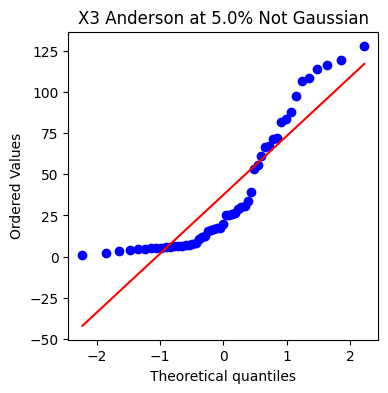

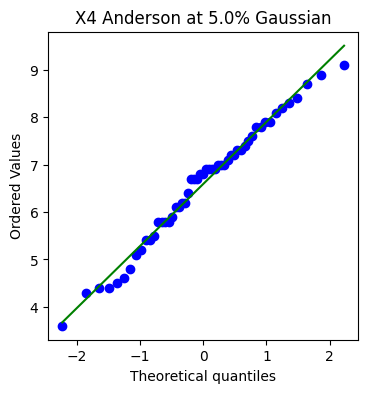

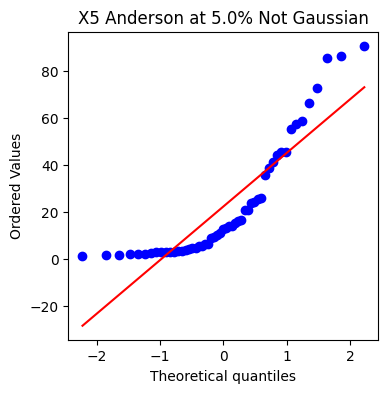

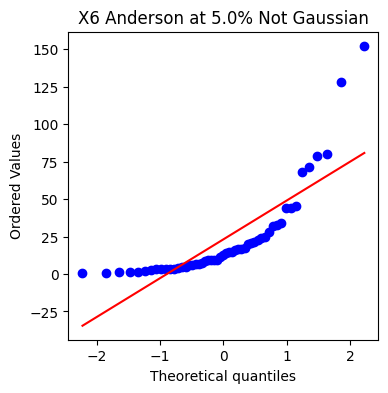

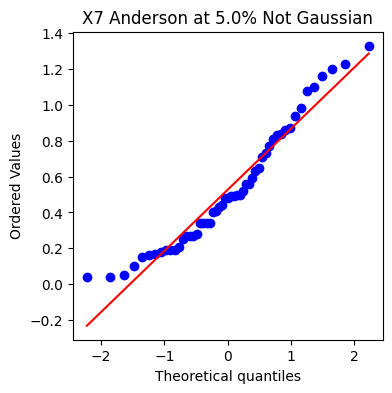

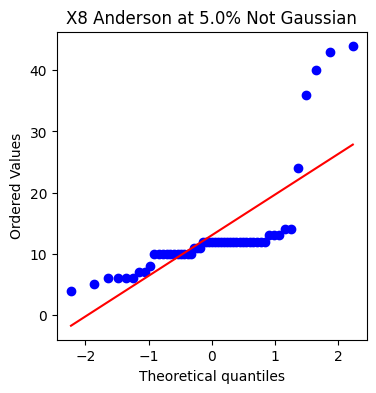

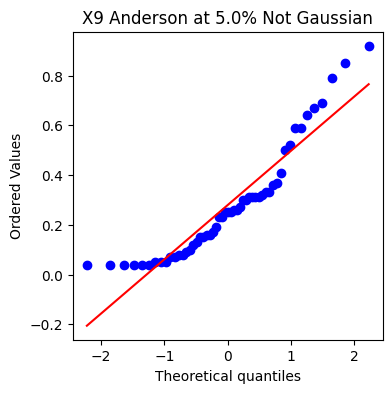

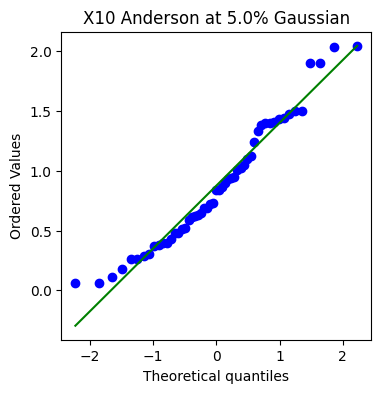

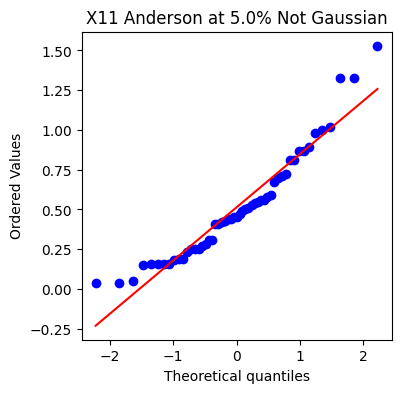

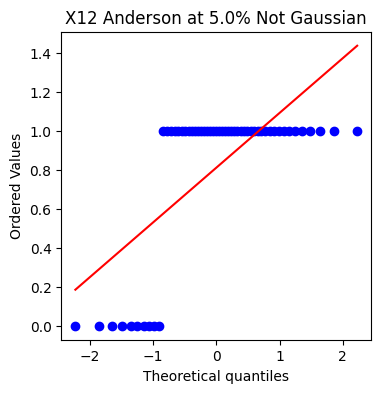

In [9]:
for col in data.columns:
    analysis_df = data[col]
    result = anderson(analysis_df)
    sl, cv = result.significance_level[2], result.critical_values[2]
    eval_stat = "Gaussian" if result.statistic < cv else "Not Gaussian"
    fig, (ax) = plt.subplots(figsize = (4,4))
    res = probplot(analysis_df,dist="norm", plot=ax)    
    ax.set_title(f"{col} Anderson at {sl}% {eval_stat}")
    ax.get_lines()[1].set_color("g") if result.statistic < cv else ax.get_lines()[1].set_color("r")

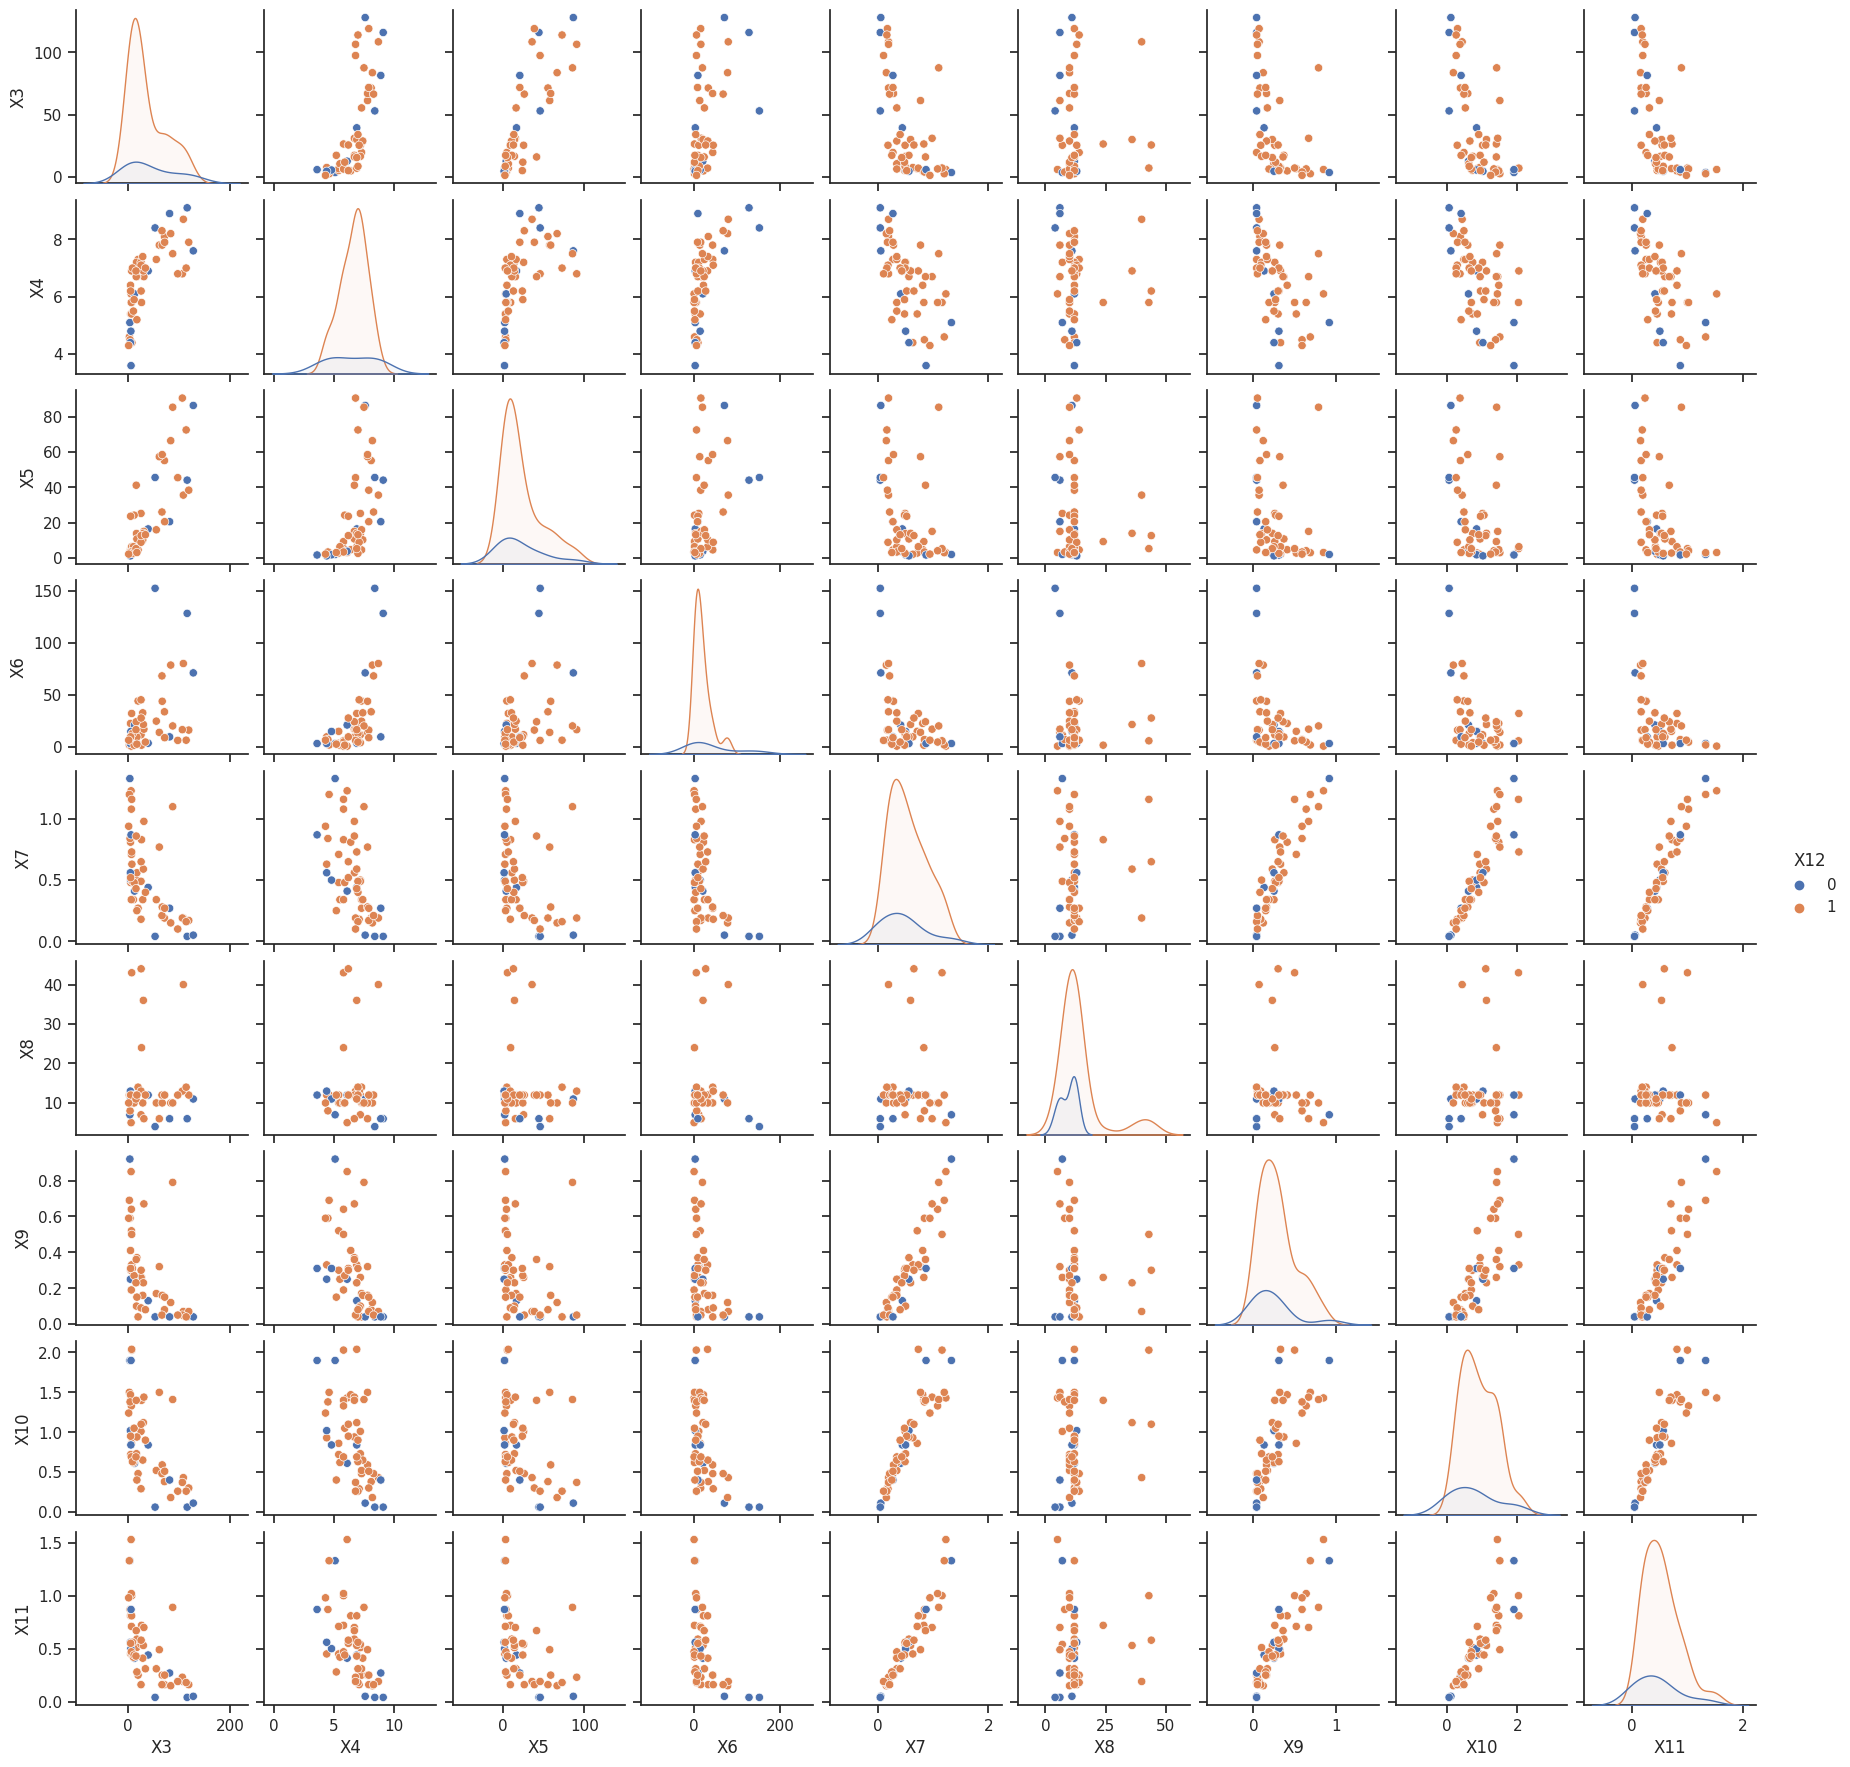

In [10]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data, kind="scatter", hue = "X12", diag_kws={'alpha':.05}, height=2)
plt.show()

# Multivariate of just the normal variables

## Mardia

In [11]:
mardia(data[["X4","X10"]])

Multivariate Skewness 0.7402136949443168
Statistic 6.538554305341465
P-Value 0.16237730235450726
Normality yes

Multivariate Kurtosis 7.022738670293162
Statistic 0.7908922569787501
P-Value 0.3738304629001151
Normality yes


## HZ

In [12]:
multivariate_normality(data[["X4","X10"]], alpha=.05)

HZResults(hz=0.7695729297184755, pval=0.10247634232414388, normal=True)

In [13]:
scaler = StandardScaler()
data["x4_scaled"] = scaler.fit_transform(data[["X4"]])
scaler = StandardScaler()
data["x10_scaled"] = scaler.fit_transform(data[["X10"]])

In [14]:
# Multivariete n

# Multivariete Normality Contour

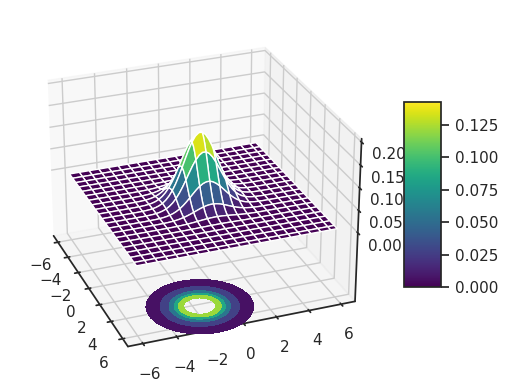

In [15]:
# https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
N = 60
X = np.linspace(-6, 6, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


sigma = [[ data.x4_scaled.std(),0],
         [0,data.x10_scaled.std()]]
# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, data[["x4_scaled","x10_scaled"]].mean(axis=0).values.T, sigma)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
cset = ax.contourf(X, Y, Z, [ 0.001, 0.01, 0.03, 0.05, .07, .1], zdir='z', offset=-0.25, cmap=cm.viridis)

# Adjust the limits, ticks and view angle

ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Outliers de la normal multivariada

## Outliers in all columns

In [16]:
outliers_df = data.iloc[:, :10]
k = len(outliers_df.columns)
outliers_df.head()

,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
0,5.9,6.1,3.0,0.7,1.23,5,0.85,1.43,1.53,1
1,3.5,5.1,1.9,3.2,1.33,7,0.92,1.90,1.33,0
2,116.0,9.1,44.1,128.3,0.04,6,0.04,0.06,0.04,0
3,39.4,6.9,16.4,3.5,0.44,12,0.13,0.84,0.44,0
4,2.5,4.6,2.9,1.8,1.20,12,0.69,1.50,1.33,1


### Mahalanobis Distance

In [17]:
outliers_df['mahalanobis'] = calculateMahalanobis(y=outliers_df, data=outliers_df)
outliers_df['p'] = 1 - chi2.cdf(outliers_df['mahalanobis'], k)

### Rows that are outliers

In [18]:
outliers_df[outliers_df["p"] < .05]

,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,mahalanobis,p
0,5.9,6.1,3.0,0.7,1.23,5,0.85,1.43,1.53,1,23.232320,0.009921
16,108.5,8.7,35.6,80.1,0.19,40,0.07,0.43,0.19,1,18.510929,0.046933
23,7.0,6.9,6.3,32.1,0.73,12,0.33,2.04,0.81,1,27.306254,0.002329
32,5.8,3.6,1.6,3.2,0.87,12,0.31,1.90,0.87,0,20.823964,0.022355
37,53.0,8.4,45.6,152.4,0.04,4,0.04,0.06,0.04,0,23.879954,0.007925
39,87.6,7.5,85.5,20.1,1.10,10,0.79,1.41,0.89,1,20.058489,0.028704
47,81.5,8.9,20.5,9.6,0.27,6,0.04,0.40,0.27,0,19.297102,0.036647


### Q-Q Plot
A Q-Q plot can be used to picture the Mahalanobis distances for the sample. The basic idea is the same as for a normal probability plot. For multivariate data, we plot the ordered Mahalanobis distances versus estimated quantiles (percentiles) for a sample of size n from a chi-squared distribution with p degrees of freedom. This should resemble a straight-line for data from a multivariate normal distribution. Outliers will show up as points on the upper right side of the plot for which the Mahalanobis distance is notably greater than the chi-square quantile value. - *(“4.4 - Multivariate Normality and Outliers | STAT 505,” 2022)*

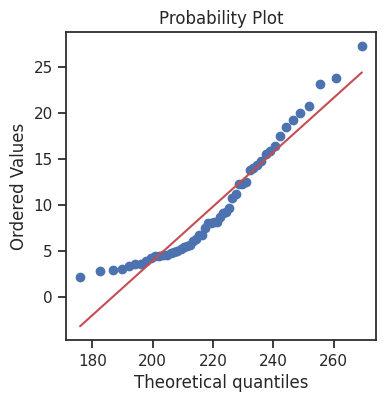

In [19]:
fig, (ax) = plt.subplots(figsize = (4,4))
gl = k*(k+1)*(k+2)/6
res = probplot(outliers_df['mahalanobis'],dist=stats.chi2, sparams=(gl), plot=ax)    

## Outliers in X4, X10 columns

In [20]:
outliers_2 = data[["X4", "X10"]]
k = len(outliers_2.columns)
outliers_2.head()

,X4,X10
0,6.1,1.43
1,5.1,1.90
2,9.1,0.06
3,6.9,0.84
4,4.6,1.50


### Mahalanobis Distance

In [21]:
outliers_2['mahalanobis'] = calculateMahalanobis(y=outliers_2, data=outliers_2)
outliers_2['p'] = 1 - chi2.cdf(outliers_2['mahalanobis'], k)

/tmp/ipykernel_847/699131037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_2['mahalanobis'] = calculateMahalanobis(y=outliers_2, data=outliers_2)
/tmp/ipykernel_847/699131037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_2['p'] = 1 - chi2.cdf(outliers_2['mahalanobis'], k)


### Rows that are outliers

In [22]:
outliers_2[outliers_2["p"] < .08]

,X4,X10,mahalanobis,p
13,5.8,2.03,5.430035,0.066204
17,7.8,1.50,5.115416,0.077482
23,6.9,2.04,8.099887,0.017423
32,3.6,1.90,6.059085,0.048338


#### Q-Q PLot

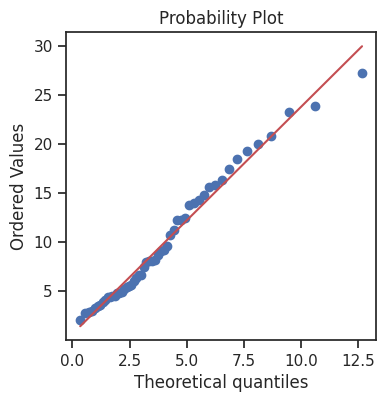

In [23]:
fig, (ax) = plt.subplots(figsize = (4,4))
gl = k*(k+1)*(k+2)/6
res = probplot(outliers_df['mahalanobis'], dist=stats.chi2, sparams=(gl), plot=ax)    

# PCA

## Vectors Visualization - First 2 components

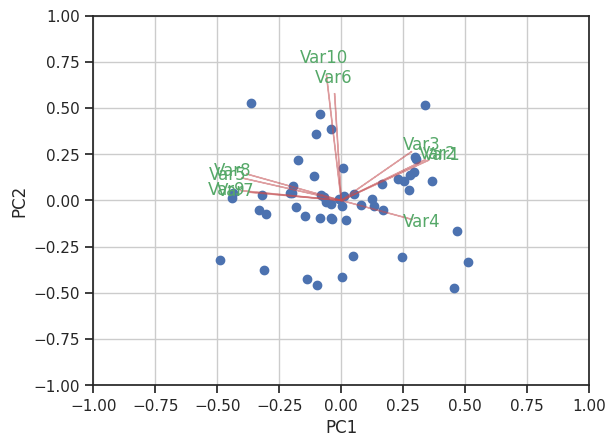

In [24]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

scaled = StandardScaler().fit_transform(data.iloc[:, :10])
pca = PCA().fit(scaled)
principalComponents = pca.fit_transform(scaled)

myplot(principalComponents[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

In [91]:
contribution = pd.DataFrame(pca.components_,columns=data.iloc[:, :10].columns)
contribution["PC#"] = "PC" + contribution.index.astype(str)
contribution

,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,PC#
0,0.350659,0.337004,0.281683,0.283342,0.398308,0.026676,0.368392,0.378938,0.402061,0.059314,PC0
1,0.216916,0.219409,0.262507,0.101951,0.121042,0.575562,0.044325,0.142372,0.052795,0.674210,PC1
2,0.347291,0.236097,0.511378,0.263961,0.299664,0.305063,0.387686,0.202490,0.256232,0.229445,PC2
3,0.009131,0.017242,0.146950,0.432676,0.080630,0.692855,0.044659,0.167921,0.042242,0.521816,PC3
4,0.340505,0.393960,0.362059,0.630934,0.030469,0.196464,0.132360,0.026781,0.056074,0.372531,PC4
5,0.075475,0.731210,0.313423,0.441122,0.074369,0.059267,0.196025,0.266718,0.038639,0.216130,PC5
6,0.338235,0.086296,0.343122,0.134352,0.013778,0.146931,0.456741,0.673766,0.233878,0.057595,PC6
7,0.686230,0.287692,0.455688,0.190070,0.016748,0.168095,0.182605,0.336029,0.026134,0.164512,PC7
8,0.042840,0.013636,0.115083,0.063331,0.062433,0.025320,0.538036,0.188449,0.806483,0.027827,PC8
9,0.022398,0.044453,0.026347,0.039824,0.848276,0.048060,0.350205,0.304452,0.240180,0.018397,PC9


In [92]:
contribution = contribution.melt(id_vars="PC#")
contribution.head()

,PC#,variable,value
0,PC0,X3,0.350659
1,PC1,X3,0.216916
2,PC2,X3,0.347291
3,PC3,X3,0.009131
4,PC4,X3,0.340505


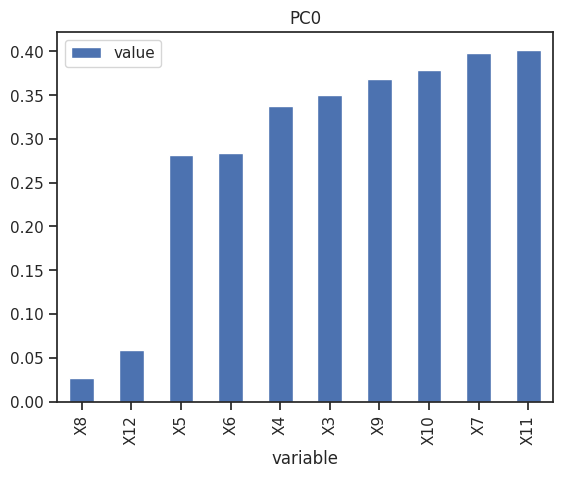

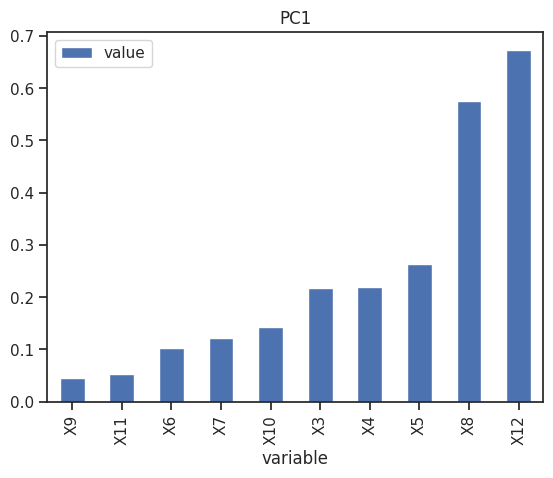

In [98]:
contribution.update(contribution.select_dtypes(include=[np.number]).abs())

for princ_comp in contribution["PC#"].unique()[:2]:
    contribution[contribution["PC#"]== princ_comp].sort_values(by="value").plot.bar(x ="variable", title=princ_comp)

## Correlation Matrix to explain the need of PCA

<AxesSubplot: >

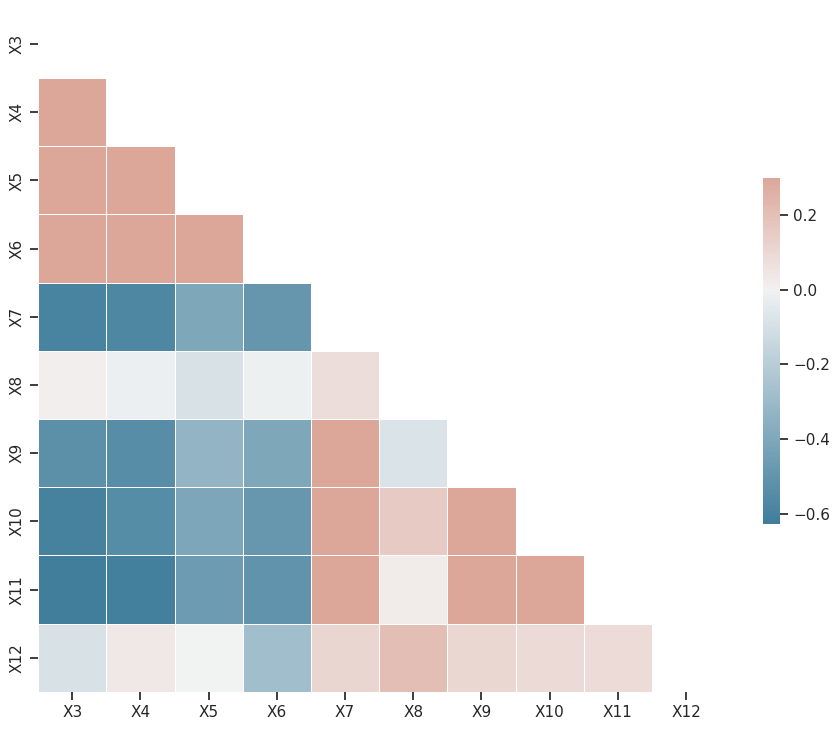

In [ ]:
corr = data.iloc[:, :10].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Number of components needed 

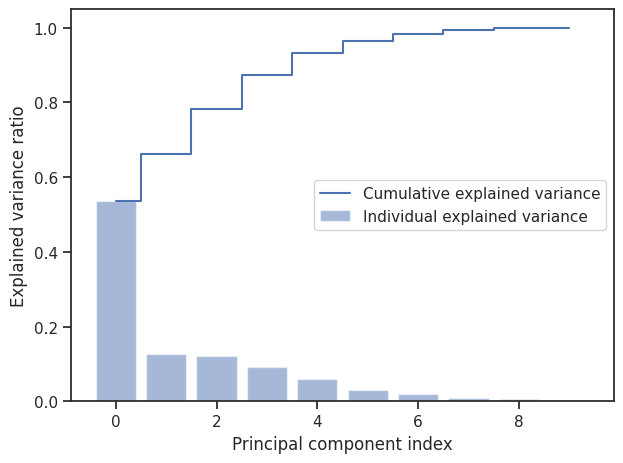

In [ ]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user 
!jupyter nbextension enable codefolding/main
!python -m pip install -U notebook-as-pdf
!pyppeteer-install

[I 11:31:46 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 11:31:46 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 11:31:46 InstallContribNbextensionsApp] Installing /home/armando/.local/share/virtualenvs/school-54vk9BCB/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad -> scratchpad
[I 11:31:46 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/LICENSE
[I 11:31:46 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/README.md
[I 11:31:46 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/scratchpad.yaml
[I 11:31:46 InstallContribNbextensionsApp] Up to date: /home/armando/.local/share/jupyter/nbextensions/scratchpad/scratchpad.css
[I 11:31:46 InstallContribNbextensionsApp] Up to date: /home/armando/.local/sh

In [ ]:
!jupyter-nbconvert multivariete.ipynb --no-input --no-prompt --to html

[NbConvertApp] WARNING | pattern 'multivariete.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
  